In [1]:
import os
print(os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"))

['Uninfected', 'Parasitized']


In [2]:
!pip install pyxtend

In [3]:
import inspect
from pyxtend import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

from sklearn.metrics import auc, roc_curve, precision_recall_curve, classification_report

In [4]:
#Setup Gdrive file download extention 
#!conda install -y gdown

In [6]:
path = Path(("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"))
path.ls()

(#2) [Path('/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected'),Path('/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized')]

In [7]:
blocks = ImageBlock, CategoryBlock

In [8]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
item_tfms = [Resize(224)]
batch_tfms = [*aug_transforms(flip_vert=True, max_rotate=10.0, max_zoom = 1.1, max_warp = 0), Normalize.from_stats(*imagenet_stats)]

In [9]:
data_block = DataBlock(blocks = blocks,
                       get_items = get_image_files,
                       get_y = parent_label,
                       splitter = splitter,
                       item_tfms = item_tfms,
                       batch_tfms = batch_tfms
)

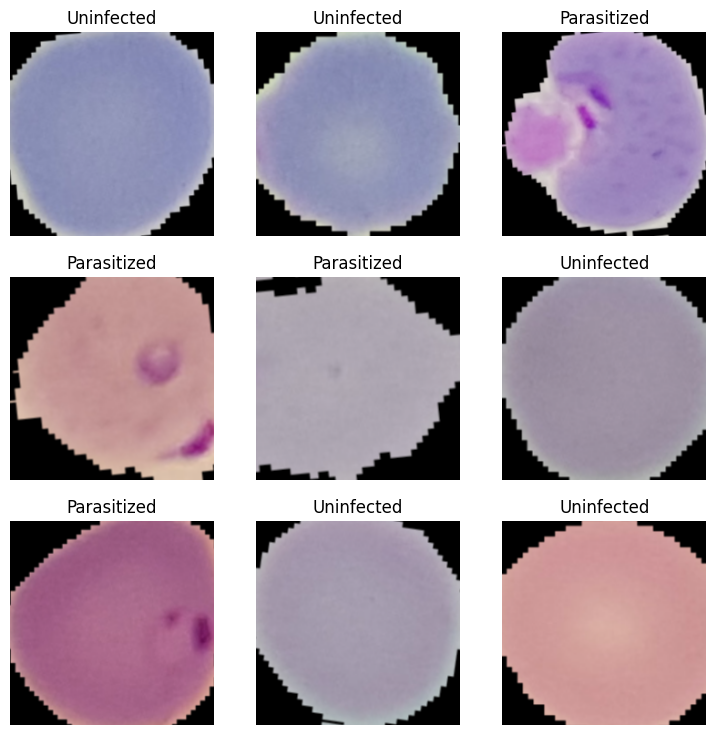

In [10]:
data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [11]:
print(f"Total images: {len(data.train_ds) + len(data.valid_ds)}")
print(f"Training images: {len(data.train_ds)}")
print(f"Validation images: {len(data.valid_ds)}")
print(f"Classes: {data.vocab}")

Total images: 27558
Training images: 22047
Validation images: 5511
Classes: ['Parasitized', 'Uninfected']


In [12]:
learn = vision_learner(data, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s] 


/opt/conda/lib/python3.10/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(minimum=0.014454397559165954, steep=0.0030199517495930195, valley=0.0030199517495930195, slide=0.02290867641568184)

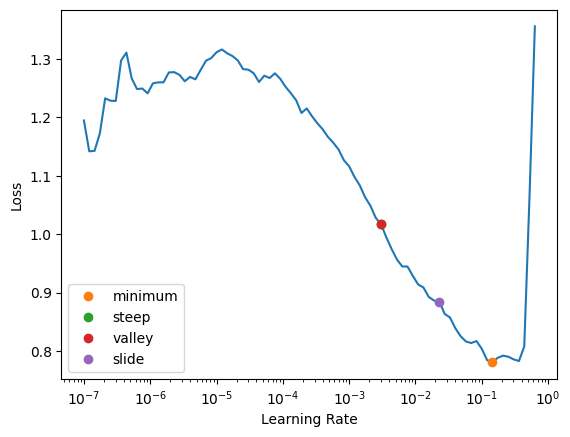

In [13]:
# Find a good learning rate
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [14]:
#chosen_lr = 0.0010000000474974513
chosen_lr = 0.0030199517495930195

In [15]:
epochs = 15
freeze_epochs = 5
lr_max = chosen_lr

# Freeze layers and train
learn.freeze()
learn.fit_one_cycle(freeze_epochs, lr_max=lr_max / 2)

# Unfreeze and continue training
learn.unfreeze()
learn.fit_one_cycle(epochs - freeze_epochs, lr_max=slice(lr_max / 10, lr_max))

epoch,train_loss,valid_loss,error_rate,time
0,0.248669,0.142381,0.048993,01:50
1,0.164467,0.122286,0.044638,01:37
2,0.131268,0.109244,0.039739,01:37
3,0.123584,0.094098,0.035565,01:37
4,0.105832,0.093981,0.035202,01:33


epoch,train_loss,valid_loss,error_rate,time
0,0.137488,0.104770,0.034477,02:02
1,0.165991,0.135839,0.045908,02:02
2,0.163004,0.116240,0.035384,02:05
3,0.138415,0.107676,0.036654,02:06
4,0.127312,0.097545,0.033932,02:06
5,0.117304,0.101275,0.033932,02:02
6,0.109647,0.085598,0.028851,02:02
7,0.090571,0.077339,0.028670,02:01
8,0.084110,0.076941,0.027400,02:02
9,0.088089,0.076253,0.027037,02:02


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

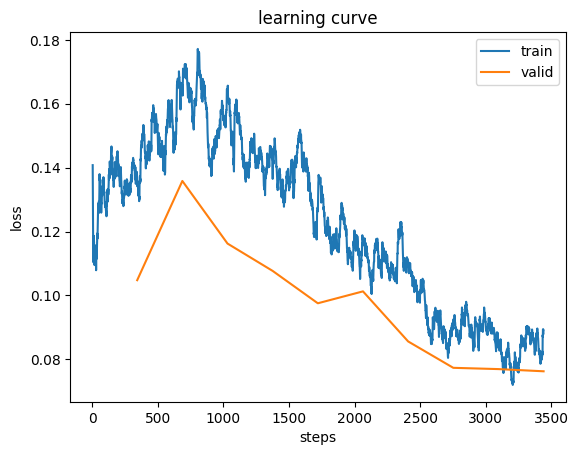

In [16]:
# After training, you can check the results
learn.recorder.plot_loss()


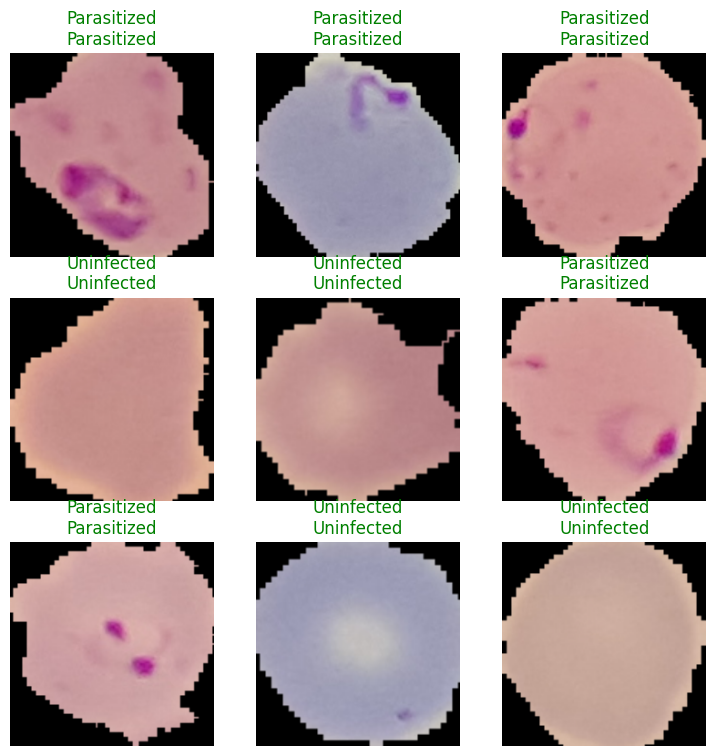

In [17]:
learn.show_results()

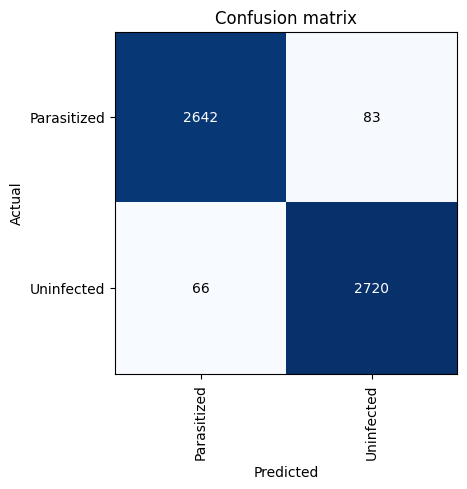

In [18]:
# Plot the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [19]:
preds, y_true=learn.get_preds()
y_true.shape, preds.shape

(torch.Size([5511]), torch.Size([5511, 2]))

In [20]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((5511,), (5511,))

In [21]:
classes = list(data.vocab)
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.98      0.97      0.97      2725
  Uninfected       0.97      0.98      0.97      2786

    accuracy                           0.97      5511
   macro avg       0.97      0.97      0.97      5511
weighted avg       0.97      0.97      0.97      5511



In [22]:
from sklearn.metrics import roc_curve, auc
preds, y_true = learn.get_preds()
fpr, tpr, thresholds = roc_curve(y_true, preds[:,1])
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score}")


AUC: 0.9962845683199748


In [23]:
learn.export('malaria_detection_model.pkl')


In [24]:
learn.save('malaria_model_weights')

Path('models/malaria_model_weights.pth')

In [25]:
!ls /kaggle/working


malaria_detection_model.pkl  models


In [ ]:
# Train the model
#learn.fine_tune(15, freeze_epochs=5, base_lr = chosen_lr)

NameError: name 'learn' is not defined

In [ ]:
# Evaluate the model
learn.show_results()


In [ ]:
# Plot the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Save the model
learn.export('malaria_model.pkl')

In [ ]:
learn.save('stage-1')